In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm
from torchaudio.datasets import SPEECHCOMMANDS
import os

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

#Additional Info when using cuda
if device == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    print('Available:   ', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda device
NVIDIA GeForce RTX 3080
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Available:    9.8 GB


In [3]:
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

100%|██████████| 2.26G/2.26G [01:07<00:00, 36.0MB/s]


Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


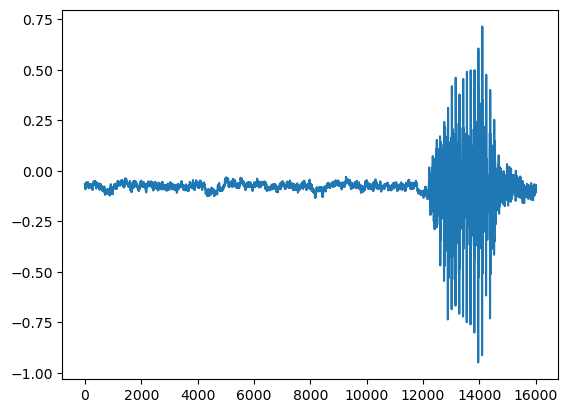

In [4]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))
plt.plot(waveform.t().numpy())

In [5]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

In [6]:
len(labels)

35

In [7]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

In [8]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

In [9]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate, autoplay=True)

In [10]:
%matplotlib inline

In [11]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate, autoplay=True)

In [12]:
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

In [13]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)